In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import datetime
import numpy as np
from datetime import date
from  time import sleep

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials

import warnings
warnings.filterwarnings("ignore")

from config import *

In [263]:
def getting_df(url):
    response = requests.get(url)
    response.status_code # 200 status code means OK!
    soup = BeautifulSoup(response.content, "html.parser")
    artist = []
    song = []

    for tag in soup.select(".chart-element__information__artist"):
        artist.append(tag.get_text())

    for tag in soup.select(".chart-element__information__song"):
        song.append(tag.get_text())

    d = {'artist': artist, 'song': song}
    df = pd.DataFrame(d,columns = ['artist','song'])
    df.drop_duplicates(inplace=True)
    df['creation_ddbb'] = date.today()
    return df

In [264]:
def updating_df(url,df):
    response = requests.get(url)
    response.status_code # 200 status code means OK!
    soup = BeautifulSoup(response.content, "html.parser")
    new_artist = []
    new_song = []
    for tag in soup.select(".chart-element__information__artist"):
        new_artist.append(tag.get_text())
    for tag in soup.select(".chart-element__information__song"):
        new_song.append(tag.get_text().capitalize())
    for s in list(df.song):
        if s not in new_song:
            df.drop(list(df[df.song == s].index))
    for s in new_song:
        if s not in list(df.song):
            new_row = {'artist': new_artist[new_song.index(s)] ,'song': s,'creation_ddbb': date.today()}
            df = df.append(new_row, ignore_index=True)
    df.to_csv('billboard_music_db.csv', index=False)
    return df
# second url to try: https://www.billboard.com/charts/billboard-200


In [577]:
df = pd.read_csv('billboard_music_db.csv')
df.head()

,artist,song,creation_ddbb
0,Olivia Rodrigo,Drivers license,2021-02-23
1,Ariana Grande,34+35,2021-02-23
2,Lil Tjay Featuring 6LACK,Calling my phone,2021-02-23
3,The Weeknd,Blinding lights,2021-02-23
4,Cardi B,Up,2021-02-23


Lab | API wrappers - Create your collection of songs & audio features

Instructions
To move forward with the project, you need to create a collection of songs with their audio features - as large as possible!

These are the songs that we will cluster. And, later, when the user inputs a song, we will find the cluster to which the song belongs and recommend a song from the same cluster. The more songs you have, the more accurate and diverse recommendations you'll be able to give. Although... you might want to make sure the collected songs are "curated" in a certain way. Try to find playlists of songs that are diverse, but also that meet certain standards.

The process of sending hundreds or thousands of requests can take some time - it's normal if you have to wait a few minutes (or, if you're ambitious, even hours) to get all the data you need.

An idea for collecting as many songs as possible is to start with all the songs of a big, diverse playlist and then go to every artist present in the playlist and grab every song of every album of that artist. The amount of songs you'll be collecting per playlist will grow exponentially!

In [4]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= spotify_client_id,
                                                           client_secret= spotify_client_secret))

In [5]:
def get_playlist_tracks(username, playlist_id):
    '''return songs from playlist'''
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [9]:
# extract song names and artists from playlist
def song_artist(username, playlist_id):
    '''return artist's songs from songs from playlist'''
    song_artist_dict = {}
    playlist_tracks = get_playlist_tracks(username, playlist_id)
    playlist_len = len(playlist_tracks)
    
    for i in range(playlist_len):
        song_name = playlist_tracks[i]['track']['name']
        song_id = playlist_tracks[i]['track']['id']
        singer = playlist_tracks[i]['track']['artists'][0]['name']
        song_artist_dict[singer] = {'song_name':song_name,'song_id':song_id}
        sleep(1)
    return song_artist_dict

In [77]:
def artist_songs(song_artist_dict):
    '''returns a dictionary with the artists and their songs and respective info'''
    dict_songs_artist = {}
    for artist in song_artist_dict.keys():
        songs = sp.search(q=artist,limit=50)
        dict_songs = {}
        for i in range(50):
            try:
                song = songs["tracks"]["items"][i]['name']
                if song not in list(dict_songs_artist.get(artist,{}).keys()):
                    dict_songs[song] = sp.audio_features(songs["tracks"]["items"][0]["uri"])[0]
            except:
                break    
        dict_songs_artist[artist] = dict_songs
    return dict_songs_artist

In [191]:
def create_df(info):
    '''create df of the songs and their info'''
    danceability = []
    energy =[]
    key = []
    loudness = []
    mode = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    liveness = []
    valence =[]
    tempo = []
    _type = []
    _id = []
    uri = []
    duration_ms = []
    time_signature = [] 
    song =[]
    artist = []

    for artist_ in info.keys():
        for song_ in info.get(artist_,{}).keys():
            features = {'song':song,'artist':artist,'danceability':danceability,'energy':energy,'key':key,'loudness':loudness,'mode':mode,'speechiness':speechiness,'instrumentalness':instrumentalness,'liveness':liveness,'valence':valence,'tempo':tempo,'type':_type,'id':_id,'uri':uri,'duration_ms':duration_ms,'time_signature':time_signature}
            for i,v in features.items():
                if i == 'artist':
                    feature = artist_
                elif i == 'song':
                    feature = song_
                else:
                    feature = info.get(artist_,{}).get(song_)[i]
                v.append(feature)

        new_dict ={}
        for i,v in features.items():
            new_dict[i] = v
    
    df = pd.DataFrame(new_dict)
    #df.to_csv('db_spotify_project.csv')
    return df

In [10]:
song_artist_dict = song_artist("alwaysfighter", "4QOTdWe1tig5hSsINrCKkW")
#"4rnleEAOdmFAbRcNCgZMpY" 5000 songs
# possible playlists to test
#"5Rrf7mqN8uus2AaQQQNdc1" 500 top hit songs
#"43Q8AWJBVTzAl1XPWyPKZQ" 500 rare songs
#"4uoPRLaoEtvHXuoTuIM387" 1519 songs
#"0BnvDJToAhcWJDaCb2M7pz" small list
#"4QOTdWe1tig5hSsINrCKkW" really small list
#0lNwm5xFEgRx4iDP2DLx3j 10 songs


In [189]:
x = artist_songs(song_artist_dict)
data = create_df(x)

In [194]:
df = data.select_dtypes(np.number)
X_prep = StandardScaler().fit_transform(df)
X_prep = pd.DataFrame(X_prep, columns=df.columns)

In [195]:
kmeans = KMeans(n_clusters=5,
                init="random", 
                n_init=3,  # try with 1, 4, 8, 20, 30, 100...
                max_iter=2,
                tol=0,
                algorithm="full",
                random_state=1234)
kmeans.fit(X_prep)
print(kmeans.inertia_)

608.9849074793322


In [448]:
clusters = kmeans.predict(X_prep)
pd.Series(clusters).value_counts().sort_index()

0    1226
1     937
2    2115
3     442
4     864
dtype: int64

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

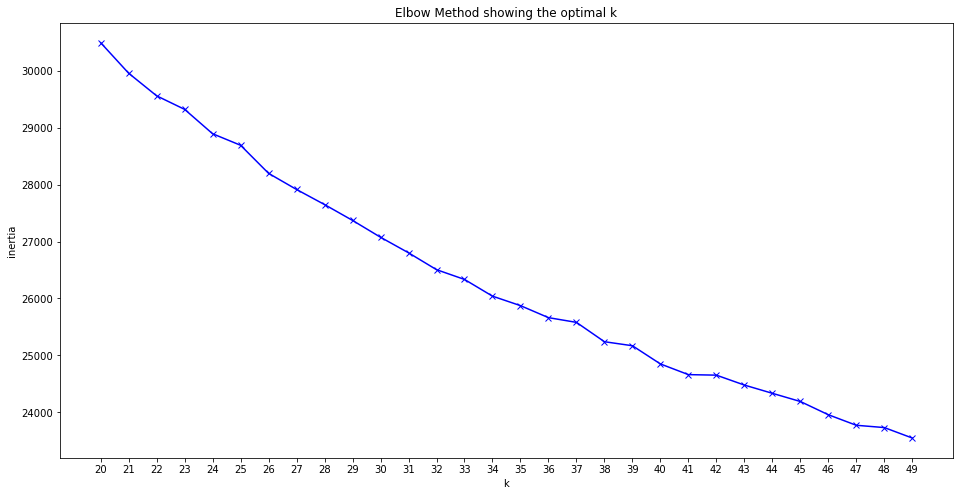

In [449]:
K = range(20, 50)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

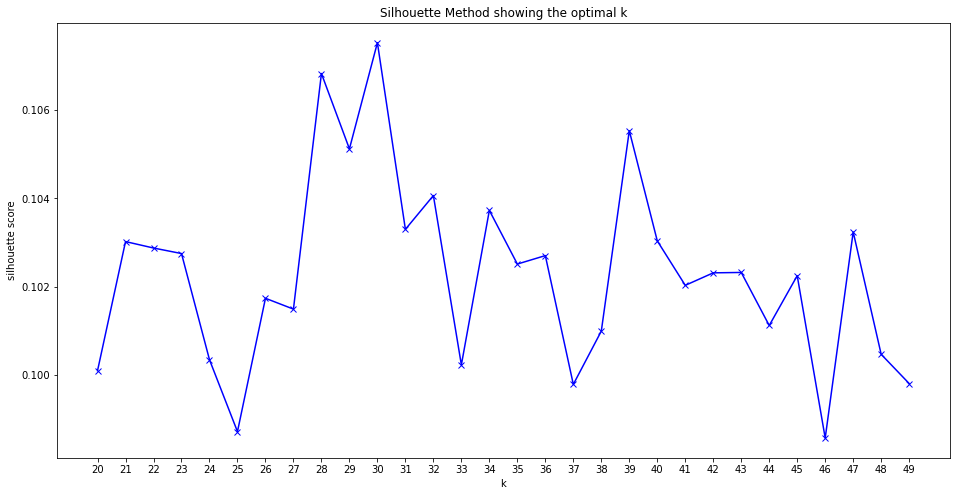

In [450]:
K = range(20, 50)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

In [ ]:
# we can choose 29,27,39

In [451]:
# TEST 2
kmeans = KMeans(n_clusters=50,
                n_init=20,  # try with 1, 4, 8, 20, 30, 100...
                max_iter=20,
                tol=0,
                algorithm="full",
                random_state=1234)
kmeans.fit(X_prep)
print(kmeans.inertia_)

23486.787045187328


Text(0.5, 1.0, 'Elbow Method showing the optimal k')

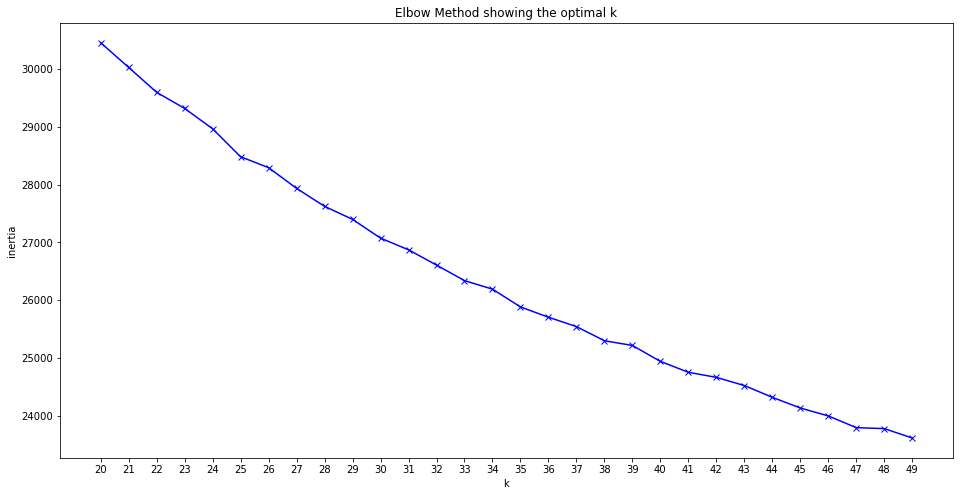

In [452]:
# TEST 2
K = range(20, 50)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                n_init=20,  # try with 1, 4, 8, 20, 30, 100...
                max_iter=20,
                tol=0,
                algorithm="full",
                random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

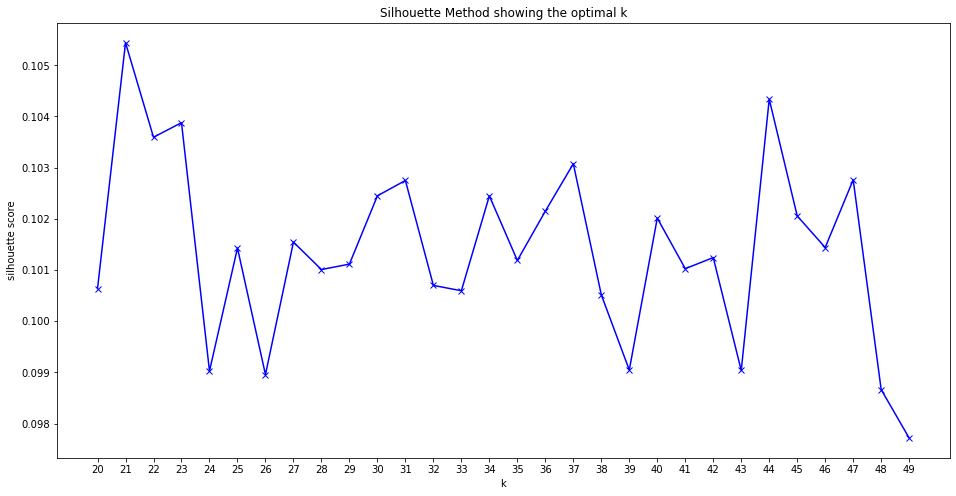

In [453]:
# TEST 2
K = range(20, 50)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                n_init=20,  # try with 1, 4, 8, 20, 30, 100...
                max_iter=20,
                tol=0,
                random_state=1234)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

In [454]:
# we choose 21,44

In [456]:
# first thing morning
model = KMeans(n_clusters=44, random_state=0).fit(X_prep)
# fit model and predict clusters
yhat = model.fit_predict(X_prep)

In [457]:
# retrieve unique clusters
clusters = np.unique(yhat)
clusters

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43], dtype=int32)

In [458]:
yhat

array([ 1, 25, 18, ..., 34, 26, 16], dtype=int32)

In [459]:
X_prep

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,-0.125565,0.662780,-1.191943,-0.108308,0.692530,-0.499804,-0.870072,-0.427814,-0.655783,0.410341,-0.684378,0.436458
1,1.629373,-0.539805,-1.471306,0.412062,0.692530,-0.497760,1.045914,-0.434769,-0.573573,0.663102,0.290969,0.088301
2,-0.265960,-0.824287,-0.912581,-0.630858,0.692530,-0.584639,-0.914191,0.954148,-0.311256,-1.772231,-0.363152,0.629677
3,1.266686,-0.569977,-1.191943,-0.082159,0.692530,-0.044968,0.982877,-0.201238,-0.717283,0.277942,-0.861802,0.004036
4,-0.271810,1.317952,-0.912581,0.529952,0.692530,-0.365909,-0.868413,-0.429966,1.063088,-0.404112,0.540865,0.103586
...,...,...,...,...,...,...,...,...,...,...,...,...
5579,0.634908,-0.376012,0.763594,-1.158855,-1.443982,0.166608,-0.886130,-0.435289,-0.417940,0.137519,0.083143,-1.331661
5580,1.793167,-0.807046,-1.471306,-1.063193,-1.443982,-0.161488,-0.822961,-0.431798,-1.002820,1.481566,0.255200,1.154858
5581,1.266686,0.585194,-0.912581,-0.406192,-1.443982,-0.519224,-0.635177,-0.405348,-0.869151,1.638037,0.382832,0.552310
5582,-1.067381,0.796400,-1.191943,0.220955,0.692530,3.284029,-0.728405,1.916969,-0.104163,0.045241,-1.401761,0.418067


In [460]:
# MERGE CLUSTER COLUMN WITH THE ORIGINAL DATA
data['cluster'] = yhat
data

,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,duration_ms,cluster
0,I Still Haven't Found What I'm Looking For,0.564,0.774,1,-9.424,1,0.0368,0.013500,0.001910,0.0861,0.657,100.894,audio_features,6wpGqhRvJGNNXwWlPmkMyO,spotify:track:6wpGqhRvJGNNXwWlPmkMyO,277477,1
1,Somebody That I Used To Know,0.864,0.495,0,-7.036,1,0.0370,0.591000,0.000133,0.0992,0.720,129.062,audio_features,4wCmqSrbyCgxEXROQE6vtV,spotify:track:4wCmqSrbyCgxEXROQE6vtV,244973,25
2,With Or Without You - Remastered,0.540,0.429,2,-11.822,1,0.0285,0.000202,0.355000,0.1410,0.113,110.171,audio_features,6ADSaE87h8Y3lccZlBJdXH,spotify:track:6ADSaE87h8Y3lccZlBJdXH,295516,18
3,Just the Two of Us (feat. Bill Withers),0.802,0.488,1,-9.304,1,0.0813,0.572000,0.059800,0.0763,0.624,95.770,audio_features,1ko2lVN0vKGUl9zrU0qSlT,spotify:track:1ko2lVN0vKGUl9zrU0qSlT,237106,25
4,Beautiful Day,0.539,0.926,2,-6.495,1,0.0499,0.014000,0.001360,0.3600,0.454,136.279,audio_features,1VuBmEauSZywQVtqbxNqka,spotify:track:1VuBmEauSZywQVtqbxNqka,246400,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5579,"Earth, Wind, Fire & Air",0.694,0.533,8,-14.245,0,0.1020,0.008660,0.000000,0.1240,0.589,123.060,audio_features,1kGvwKNeDpTuMDw0KWqT92,spotify:track:1kGvwKNeDpTuMDw0KWqT92,112405,4
5580,Keep the Fire Burning,0.892,0.433,0,-13.806,0,0.0699,0.027700,0.000892,0.0308,0.924,128.029,audio_features,4rS4K30qVDExdjeU4feF4c,spotify:track:4rS4K30qVDExdjeU4feF4c,344547,34
5581,Boogie Wonderland,0.802,0.756,2,-10.791,0,0.0349,0.084300,0.007650,0.0521,0.963,131.715,audio_features,6ztstiyZL6FXzh4aG46ZPD,spotify:track:6ztstiyZL6FXzh4aG46ZPD,288293,34
5582,Pizza Alley,0.403,0.805,1,-7.913,1,0.4070,0.056200,0.601000,0.1740,0.566,80.176,audio_features,0EhaHV6QmVGy0incn4IXGz,spotify:track:0EhaHV6QmVGy0incn4IXGz,275760,26


In [768]:
data.to_csv('spotify_data.csv',index=False)

In [781]:
import webbrowser
from IPython.core.display import display, HTML

def return_a_new_song(customer_song,df,data):
    customer_song = customer_song.capitalize()
    if 'play_the_song' not in data.columns:
        data['play_the_song'] = list(map(lambda x : 'https://open.spotify.com/embed/track/'+ x[14:],data[customer_song]['tracks']['items'][0]['uri']))
    if customer_song in list(df.song):
        artist_customer = df[df.song == customer_song].artist.item()
        #print(artist_customer)
        if len(df[df.artist == artist_customer]) > 1:
            customer_song_ = df[df.song == customer_song].song.item()
            results = df[df.artist == artist_customer]
            #print(results[results.song != customer_song].sample(1))

            saved_song = results[results.song != customer_song].sample(1)
            print("")
            print("")
            print("We recommend you this song: {} from {}".format(saved_song['song'].values[0], saved_song['artist'].values[0]))
            print("")
            print('Listen to it on this link: ',webbrowser.open('https://open.spotify.com/embed/track/'+sp.search(q=saved_song['song'].values[0], limit= 1)['tracks']['items'][0]['uri'][14:],new=1))

        else:
            saved_song = df.sample(1)
            print("")
            print("")
            print("We recommend you this song: {} from {}".format(saved_song['song'].values[0], saved_song['artist'].values[0]))
            print("")
            try:
                sp.search(q=saved_song['song'].values[0], limit= 1)['tracks']['items'][0]['uri']
                print('Listen to it on this link: ',webbrowser.open('https://open.spotify.com/embed/track/'+ sp.search(q=saved_song['song'].values[0], limit= 1)['tracks']['items'][0]['uri'][14:],new=1))
            except:
                link = data[data['name'] == customer_song]['play_the_song'].values[0]
                print('Listen to it on this link: ',webbrowser.open(link, new=1))
                #print('Sorry, there is no link to listen to this song.')
    elif customer_song in list(data.name):

        data[data['name'] == customer_song]['cluster'].values[0]

        data_no_song = data[data['name'] != customer_song] 

        final_data = data_no_song[data_no_song['cluster'] == cluster] 

        final_data['play_the_song'] = list(map(lambda x : 'https://open.spotify.com/embed/track/'+ x[14:],final_data['uri']))

        x = final_data[['name']].sample(1)
        
        song_name = x.values[0][0]

        try:

            link = final_data[final_data['name'] == song_name]['play_the_song'].values[0]
        except:

            link = data[data['name'] == song_name]['play_the_song'].values[0]
        print("")
        print("")
        #print("We recommend you this song: {} from {}".format(saved_song['song'].values[0], saved_song['artist'].values[0]))

        print('We recommend you this song: ',song_name)
        print("")
        print('Listen to it on this link: ',webbrowser.open(link, new=1))
    else:
        print("We couldn't find a song called {}. Plase provide another song".format(customer_song))
        return return_a_new_song(input("Choose another song: "),df,data) 

In [797]:
def display_song():
    display(HTML('<h1>Welcome to Focus break time game!</h1>'))
    sleep(1)
    customer_song = input('Choose a song: ')
    return return_a_new_song(customer_song,df,data) 

#### Demo options:

* We have two databases created to access songs: Billboard database and  spotify database.
    * If the song is in the Billboard database it will return a hot song from that database.
    * If the song is not in the Billboard database it will return a song from the spotify database.

1. Same singer song recommendation from Billboard database when the artist appears more than once. E.g. Save YOUR TEARS

2. Random song recommendation from Billboard database when the artist has just one song there. E.g. DriVERS license

3. Song Recommendation based on a cluster approach. E.g. say my name

4. Option to write another song when it doesn't exist on the databases.

In [832]:
display_song()

Choose a song: asdf
We couldn't find a song called Asdf. Plase provide another song
Choose another song: up


We recommend you this song: Body from Megan Thee Stallion

Listen to it on this link:  True
